# Helper Code and Training Procedure:

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [106]:
def shuffle_data(images, labels):
    index=np.random.permutation(len(images))
    shuff_images, shuff_labels=images[index], labels[index]
    return shuff_images, shuff_labels

def get_split_mask(images):
    size=len(images)/5
    a=np.ones(5*size, dtype=bool)
    b=np.arange(10)
    mask=[]
    for i in range(5):
        mask.append([False if (j<(i+1)*size)&(j>=(i)*size) else x for j,x in enumerate(a)])
    return mask

def get_split_data(mask, images, labels, index):
    mask_=mask[index]
    train_images=images[mask_]
    train_labels=labels[mask_]
    inv_mask_=np.invert(mask_)
    test_images=images[inv_mask_]
    test_labels=labels[inv_mask_]
    return train_images, train_labels, test_images, test_labels

def get_accuracy(model, test_images, test_labels):
    batch_size=len(test_images[0])
    count=np.zeros(batch_size)
    pred=model.forward(test_images)
    count=[1 if np.argmax(pred[:,i], axis=0)==np.argmax(test_labels[:,i], axis=0) else 0 for i in range(batch_size)]
    correct=np.sum(count)
    accuracy=100*correct/batch_size
    return(pred, accuracy)

def SGD_mom(model, batch_images, batch_labels, l2):
    batch_size=len(batch_images[0])
    loss=model.update(batch_images, batch_labels, l2)
    return loss
    
def one_hot(labels):
    a=np.zeros((len(labels), 10))
    a[np.arange(len(labels)),labels]=1
    return a


In [68]:
def plot_images(model, images, k):
    pred=model.forward(np.transpose(images))
    pred=np.transpose(pred)
    w=10
    h=10
    fig=plt.figure(figsize=(10, 10))
    columns = 4
    rows = 5    
    for i in range(1, columns*rows +1):
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        a=top_k_pred(pred[i-1],k)
        a=str(a).replace('[','').replace(']','')    
        plt.title(a)
        plt.axis('off')
        plt.imshow(images[i-1,:].reshape(-1,28), cmap='gray')
    plt.show()

In [199]:
def add_noise(images):
    size=images.shape
    x=np.random.normal(loc=0.0, scale=10, size=size)
    noisy=np.add(images,x)
    return noisy

def labels_to_class(labels):
    return np.argmax(labels, axis=1)

def confusion_matrix(target_, pred):
    size=len(target_[0])
    target_class=labels_to_class(target_)
    pred_class=labels_to_class(pred)
    cm=np.zeros([size, size])
    for a,p in zip(target_class, pred_class):
        cm[a][p]+=1
    return cm

def cm_metrics(cm):
    diag=(np.diagonal(cm))
    psum=np.sum(cm, axis=0, dtype=np.float32)
    rsum=np.sum(cm, axis=1, dtype=np.float32)
    p=np.divide(diag, psum)
    r=np.divide(diag, rsum)
    prod=np.multiply(p,r)
    sum_=p+r
    f=2*np.divide(prod,sum_)
    a=1.*np.sum(diag)/np.sum(cm)
    return (a,p,r,f)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix',):

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_loss(train_loss, test_loss, title):
    x=200*np.arange(0, len(train_loss))
    plt.plot(x,train_loss, label='Train')
    plt.plot(x,test_loss, label='Test')
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Average Loss")
    plt.legend(loc='upper left')
    plt.show()
    
def top_k_pred(pred, k):
    sort=np.argsort(pred, axis=0)
    return sort[::-1][:k]

In [55]:
def output_cm_scores(model, images, labels):
    pred=model.forward(np.transpose(images))
    cm=confusion_matrix(pred=np.transpose(pred), target_=labels)
    a,p,r,f=cm_metrics(cm)
    print "Accuracy = "+ str(a)
    print "Precision = ", p
    print "Recall = ", r
    print "F1 Score = ", f
    target_names=['0','1','2','3','4','5','6','7','8','9']
    plot_confusion_matrix(cm,target_names)

In [221]:
class MLP(object):
    def __init__(self, input_size, h1_size, h2_size, h3_size, output_size):
        self.W1=np.random.normal(loc=0.0, scale=0.008, size=(h1_size, input_size) )
        self.W2=np.random.normal(loc=0.0, scale=0.008, size=(h2_size, h1_size) )
        self.W3=np.random.normal(loc=0.0, scale=0.008, size=(h3_size, h2_size) )
        self.W4=np.random.normal(loc=0.0, scale=0.008, size=(output_size, h3_size) )
        self.B1=np.zeros(h1_size).reshape(-1,1)
        self.B2=np.zeros(h2_size).reshape(-1,1)
        self.B3=np.zeros(h3_size).reshape(-1,1)
        self.B4=np.zeros(output_size).reshape(-1,1)
        
        self.W1_grad=np.zeros_like(self.W1)
        self.W2_grad=np.zeros_like(self.W2)
        self.W3_grad=np.zeros_like(self.W3)
        self.W4_grad=np.zeros_like(self.W4)
        self.B1_grad=np.zeros_like(self.B1)
        self.B2_grad=np.zeros_like(self.B2)
        self.B3_grad=np.zeros_like(self.B3)
        self.B4_grad=np.zeros_like(self.B4)
        
        self.W1_mom=np.zeros_like(self.W1)
        self.W2_mom=np.zeros_like(self.W2)
        self.W3_mom=np.zeros_like(self.W3)
        self.W4_mom=np.zeros_like(self.W4)
        self.B1_mom=np.zeros_like(self.B1)
        self.B2_mom=np.zeros_like(self.B2)
        self.B3_mom=np.zeros_like(self.B3)
        self.B4_mom=np.zeros_like(self.B4)
        
        
    def update(self, input_, target_, l2=0):
        batch_size=len(input_[0])

        x=input_
        h1=np.add(np.matmul(self.W1, input_), self.B1)
        a1=act[act_ind](h1)
        h2=np.add(np.matmul(self.W2, a1), self.B2)
        a2=act[act_ind](h2)
        h3=np.add(np.matmul(self.W3, a2), self.B3)
        a3=act[act_ind](h3)
        h4=np.add(np.matmul(self.W4, a3), self.B4)
        a4=Softmax(h4)

        loss=CrossEntropy(target_, a4)
        _E_h4=Softmax_CE_grad(a4, target_)

        _a3_h3=act_grad[act_ind](h3)
        _a2_h2=act_grad[act_ind](h2)
        _a1_h1=act_grad[act_ind](h1)
        
        _E_W4=np.matmul(_E_h4,np.transpose(a3))
        _E_B4=np.sum(_E_h4, axis=1).reshape(-1,1)
        _E_a3=np.matmul(np.transpose(self.W4), _E_h4)
        
        _E_h3=np.multiply(_a3_h3, _E_a3 )
        _E_W3=np.matmul(_E_h3,np.transpose(a2))
        _E_B3=np.sum(_E_h3, axis=1).reshape(-1,1)
        _E_a2=np.matmul(np.transpose(self.W3), _E_h3)
        
        _E_h2=np.multiply(_E_a2, _a2_h2)
        _E_W2=np.matmul(_E_h2, np.transpose(a1))
        _E_B2=np.sum(_E_h2, axis=1).reshape(-1,1)
        _E_a1=np.matmul(np.transpose(self.W2), _E_h2)
        
        _E_h1=np.multiply(_E_a1, _a1_h1)
        _E_W1=np.matmul(_E_h1, np.transpose(x))
        _E_B1=np.sum(_E_h1, axis=1).reshape(-1,1)
        _E_x=np.matmul(np.transpose(self.W1), _E_h1)
        
        self.W1_grad=_E_W1/batch_size+self.W1*2*l2
        self.W2_grad=_E_W2/batch_size+self.W2*2*l2
        self.W3_grad=_E_W3/batch_size+self.W3*2*l2
        self.W4_grad=_E_W4/batch_size+self.W4*2*l2
        self.B1_grad=_E_B1/batch_size
        self.B2_grad=_E_B2/batch_size
        self.B3_grad=_E_B3/batch_size
        self.B4_grad=_E_B4/batch_size
        
        self.W1_mom=gamma*self.W1_mom+lr*self.W1_grad
        self.W2_mom=gamma*self.W2_mom+lr*self.W2_grad
        self.W3_mom=gamma*self.W3_mom+lr*self.W3_grad
        self.W4_mom=gamma*self.W4_mom+lr*self.W4_grad
        self.B1_mom=gamma*self.B1_mom+lr*self.B1_grad
        self.B2_mom=gamma*self.B2_mom+lr*self.B2_grad
        self.B3_mom=gamma*self.B3_mom+lr*self.B3_grad
        self.B4_mom=gamma*self.B4_mom+lr*self.B4_grad
        
        self.W1-=self.W1_mom
        self.W2-=self.W2_mom
        self.W3-=self.W3_mom
        self.W4-=self.W4_mom
        self.B1=self.B1-self.B1_mom
        self.B2=self.B2-self.B2_mom
        self.B3=self.B3-self.B3_mom
        self.B4=self.B4-self.B4_mom

        return loss
    
    def forward(self, input_):
        x=input_
        h1=np.add(np.matmul(self.W1, input_), self.B1)
        a1=act[act_ind](h1)
        h2=np.add(np.matmul(self.W2, a1), self.B2)
        a2=act[act_ind](h2)
        h3=np.add(np.matmul(self.W3, a2), self.B3)
        a3=act[act_ind](h3)
        h4=np.add(np.matmul(self.W4, a3), self.B4)
        a4=Softmax(h4)
        return a4

In [207]:
def train(model, epochs, images, labels, fold_index):
    train_loss=[]
    test_loss=[]
    train_images, train_labels, test_images, test_labels=get_split_data(mask, images, labels, fold_index)
    num_batches=len(train_images)/batch_size
    batch_images=np.array_split(train_images, num_batches)
    batch_labels=np.array_split(train_labels, num_batches)
    for epoch in range(epochs):
        for i in range(num_batches):
            size=len(batch_images[i])
            loss=SGD_mom(model, np.transpose(batch_images[i]), np.transpose(batch_labels[i]), l2=l2)
            train_avg_loss=loss/size
            if((i)%200==0):
                print("Epoch "+str(epoch+1)+" Iteration "+str(i+1)+" : Avg Loss = "+str(train_avg_loss))
                pred, accuracy=get_accuracy(model, np.transpose(test_images), np.transpose(test_labels))
                test_avg_loss= CrossEntropy(np.transpose(test_labels), pred)/len(test_images)
                train_loss.append(train_avg_loss)
                test_loss.append(test_avg_loss)
    plot_loss(train_loss, test_loss, "Plot of loss for "+actstr[act_ind]+" for Fold "+str(fold_index+1))
    output_cm_scores(model, test_images, test_labels)
    plot_images(model, test_images[:20], 3)

In [37]:
from mnist import MNIST
data=MNIST('/home/pradeep/data/')
images, labels = data.load_training()

images=np.asarray(images)
labels=np.asarray(labels)
images, labels=shuffle_data(images, labels)
labels=one_hot(labels)

In [209]:
def train_noisy(model, epochs, images, labels, fold_index):
    train_loss=[]
    test_loss=[]
    train_images, train_labels, test_images, test_labels=get_split_data(mask, images, labels, fold_index)
    train_images=add_noise(train_images)
    num_batches=len(train_images)/batch_size
    batch_images=np.array_split(train_images, num_batches)
    batch_labels=np.array_split(train_labels, num_batches)
    for epoch in range(epochs):
        for i in range(num_batches):
            size=len(batch_images[i])
            loss=SGD_mom(model, np.transpose(batch_images[i]), np.transpose(batch_labels[i]), l2=l2)
            train_avg_loss=loss/size
            if((i)%200==0):
                print("Epoch "+str(epoch+1)+" Iteration "+str(i+1)+" : Avg Loss = "+str(train_avg_loss))
                pred, accuracy=get_accuracy(model, np.transpose(test_images), np.transpose(test_labels))
                test_avg_loss= CrossEntropy(np.transpose(test_labels), pred)/len(test_images)
                train_loss.append(train_avg_loss)
                test_loss.append(test_avg_loss)
    plot_loss(train_loss, test_loss, "Plot of loss for "+actstr[act_ind]+" for Fold "+str(fold_index+1))
    output_cm_scores(model, test_images, test_labels)
    plot_images(model, test_images[:20], 3)

In [219]:
input_size=784
h1_size=1000
h2_size=500
h3_size=250
output_size=10
gamma=0.99
lr=5e-4
l2=0
act_ind=1
batch_size=64
epochs=10
act=[Sigmoid, ReLU]
act_grad=[Sigmoid_grad, ReLU_grad]
actstr={0:'Sigmoid',1:'ReLU'}

# Training Results:

### Sigmoid Activation: Fold - 1 , Learning Rate=1e-3

/home/pradeep/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 1 Iteration 1 : Avg Loss = 2.3367683838161835
Epoch 1 Iteration 201 : Avg Loss = 2.221192781387103
Epoch 1 Iteration 401 : Avg Loss = 2.048286002040604
Epoch 1 Iteration 601 : Avg Loss = 1.8923699560086653
Epoch 2 Iteration 1 : Avg Loss = 1.8372160064081566
Epoch 2 Iteration 201 : Avg Loss = 1.5545865118355153
Epoch 2 Iteration 401 : Avg Loss = 1.28841744181361
Epoch 2 Iteration 601 : Avg Loss = 1.147916158425535
Epoch 3 Iteration 1 : Avg Loss = 1.1773038895551637
Epoch 3 Iteration 201 : Avg Loss = 0.8937112763019123
Epoch 3 Iteration 401 : Avg Loss = 0.7978156943508996
Epoch 3 Iteration 601 : Avg Loss = 0.7065680467837185
Epoch 4 Iteration 1 : Avg Loss = 0.8349643660379296
Epoch 4 Iteration 201 : Avg Loss = 0.5880228360729647
Epoch 4 Iteration 401 : Avg Loss = 0.5979728466814654
Epoch 4 Iteration 601 : Avg Loss = 0.4907225811910435
Epoch 5 Iteration 1 : Avg Loss = 0.644006512561168
Epoch 5 Iteration 201 : Avg Loss = 0.4475915749691365
Epoch 5 Iteration 401 : Avg Loss = 0.4844786

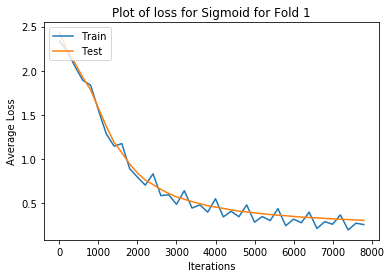

Accuracy = 0.9136666666666666
Precision =  [0.94939759 0.95658683 0.91319149 0.91574468 0.88398268 0.88602941
 0.92320396 0.94753086 0.87902524 0.86666667]
Recall =  [0.97203947 0.9638009  0.89045643 0.87479675 0.91323792 0.86690647
 0.94745763 0.91573453 0.88752197 0.89417989]
F1 Score =  [0.96058513 0.96018032 0.90168067 0.89480249 0.8983722  0.87636364
 0.93517357 0.9313614  0.88325317 0.88020833]


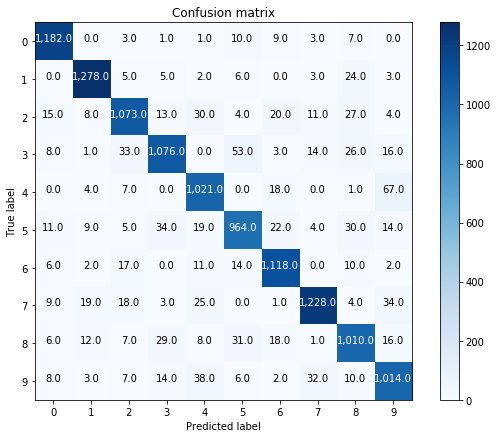

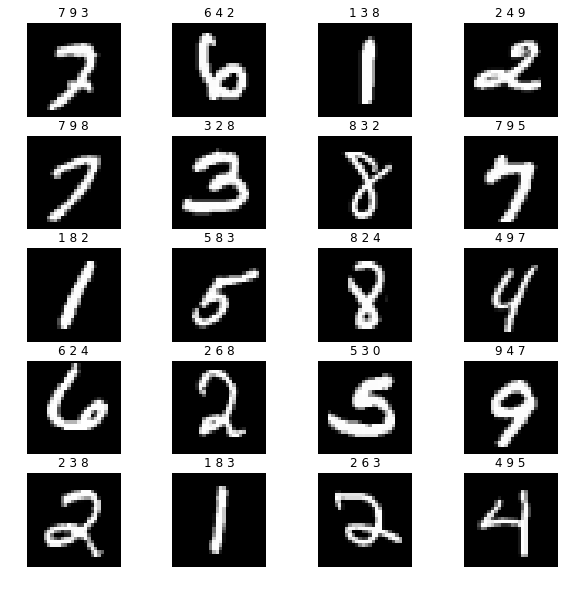

In [123]:
model0=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=0, model=model0)

### Sigmoid Activation: Fold - 2 , Learning Rate=1e-3

/home/pradeep/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 1 Iteration 1 : Avg Loss = 2.413632350576278
Epoch 1 Iteration 201 : Avg Loss = 1.4763599611971254
Epoch 1 Iteration 401 : Avg Loss = 0.5728119877426777
Epoch 1 Iteration 601 : Avg Loss = 0.3369304840454801
Epoch 2 Iteration 1 : Avg Loss = 0.30996912760051654
Epoch 2 Iteration 201 : Avg Loss = 0.2757444584824267
Epoch 2 Iteration 401 : Avg Loss = 0.301027513692861
Epoch 2 Iteration 601 : Avg Loss = 0.2878394718047479
Epoch 3 Iteration 1 : Avg Loss = 0.2556187799076809
Epoch 3 Iteration 201 : Avg Loss = 0.147169791103031
Epoch 3 Iteration 401 : Avg Loss = 0.2467639966246116
Epoch 3 Iteration 601 : Avg Loss = 0.20546931921756736
Epoch 4 Iteration 1 : Avg Loss = 0.1894123582330567
Epoch 4 Iteration 201 : Avg Loss = 0.14266005052689462
Epoch 4 Iteration 401 : Avg Loss = 0.2169508668290129
Epoch 4 Iteration 601 : Avg Loss = 0.22968838632545885
Epoch 5 Iteration 1 : Avg Loss = 0.22195646929736698
Epoch 5 Iteration 201 : Avg Loss = 0.10978473844785806
Epoch 5 Iteration 401 : Avg Loss = 

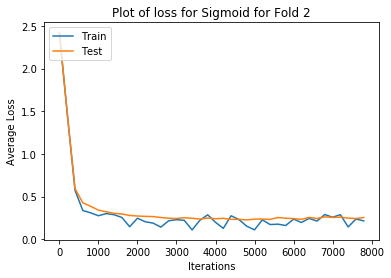

Accuracy = 0.9164166666666667
Precision =  [0.93371522 0.96646796 0.91738382 0.88235294 0.83951552 0.87932564
 0.96581946 0.91098637 0.91364421 0.96438884]
Recall =  [0.9677693  0.97592175 0.91033305 0.90645695 0.9585134  0.91759259
 0.92140468 0.93806771 0.88535565 0.78649922]
F1 Score =  [0.95043732 0.97117185 0.91384483 0.89424255 0.89507667 0.89805165
 0.94308943 0.92432872 0.89927752 0.86640726]


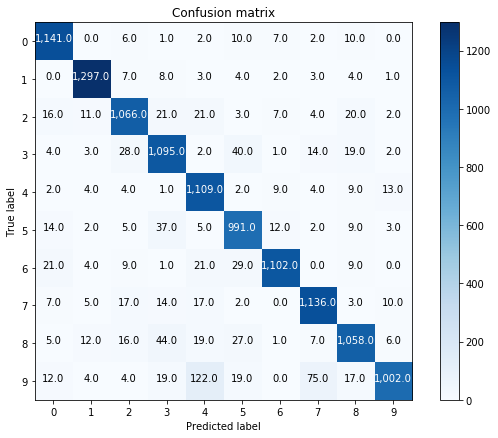

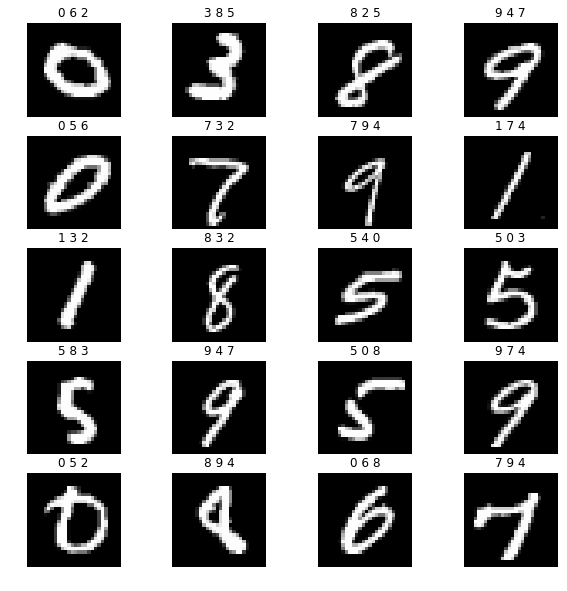

In [218]:
model1=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=1, model=model1)

### Sigmoid Activation: Fold - 3, Learning Rate=1e-3

/home/pradeep/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 1 Iteration 1 : Avg Loss = 2.3020772755924535
Epoch 1 Iteration 201 : Avg Loss = 2.224380476348154
Epoch 1 Iteration 401 : Avg Loss = 2.0439773597049395
Epoch 1 Iteration 601 : Avg Loss = 1.869690307297779
Epoch 2 Iteration 1 : Avg Loss = 1.7460432756962283
Epoch 2 Iteration 201 : Avg Loss = 1.5358653356256387
Epoch 2 Iteration 401 : Avg Loss = 1.274872134405267
Epoch 2 Iteration 601 : Avg Loss = 1.1035250259802614
Epoch 3 Iteration 1 : Avg Loss = 1.01813290366095
Epoch 3 Iteration 201 : Avg Loss = 0.8545902270202418
Epoch 3 Iteration 401 : Avg Loss = 0.7788226654858714
Epoch 3 Iteration 601 : Avg Loss = 0.7036356321426926
Epoch 4 Iteration 1 : Avg Loss = 0.6715752863064404
Epoch 4 Iteration 201 : Avg Loss = 0.5572325071014146
Epoch 4 Iteration 401 : Avg Loss = 0.5887641070630594
Epoch 4 Iteration 601 : Avg Loss = 0.5211542109890172
Epoch 5 Iteration 1 : Avg Loss = 0.48620805075200785
Epoch 5 Iteration 201 : Avg Loss = 0.4275529626185578
Epoch 5 Iteration 401 : Avg Loss = 0.47594

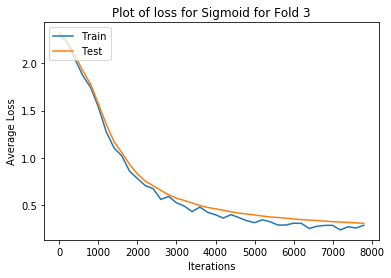

Accuracy = 0.9145
Precision =  [0.94884093 0.96050671 0.91328413 0.90225564 0.91503268 0.88058341
 0.93430034 0.9215045  0.87225042 0.88680782]
Recall =  [0.96977124 0.97577593 0.86312119 0.87662338 0.91428571 0.87978142
 0.94969644 0.92225859 0.88270548 0.9       ]
F1 Score =  [0.95919192 0.96808111 0.8874944  0.88925484 0.91465904 0.88018223
 0.94193548 0.92188139 0.87744681 0.89335521]


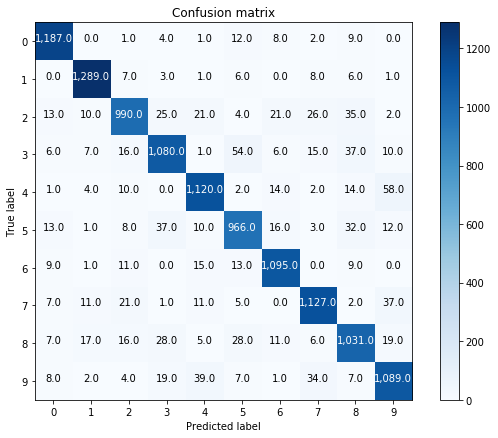

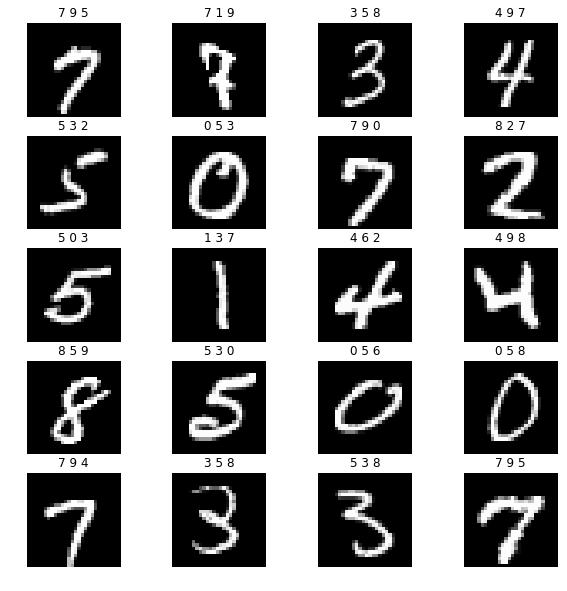

In [125]:
model2=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=2, model=model2)

### Sigmoid Activation: Fold - 4 , Learning Rate=1e-3

/home/pradeep/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 1 Iteration 1 : Avg Loss = 2.5568868818361232
Epoch 1 Iteration 201 : Avg Loss = 2.2024543522514266
Epoch 1 Iteration 401 : Avg Loss = 2.0915299806281906
Epoch 1 Iteration 601 : Avg Loss = 1.9090136088231282
Epoch 2 Iteration 1 : Avg Loss = 1.7864222634493765
Epoch 2 Iteration 201 : Avg Loss = 1.585451743077697
Epoch 2 Iteration 401 : Avg Loss = 1.3399159458246737
Epoch 2 Iteration 601 : Avg Loss = 1.1519644675312668
Epoch 3 Iteration 1 : Avg Loss = 1.0648443388955968
Epoch 3 Iteration 201 : Avg Loss = 0.9094997169944896
Epoch 3 Iteration 401 : Avg Loss = 0.736533951582886
Epoch 3 Iteration 601 : Avg Loss = 0.7189493420437372
Epoch 4 Iteration 1 : Avg Loss = 0.6904709330697907
Epoch 4 Iteration 201 : Avg Loss = 0.5864196647922397
Epoch 4 Iteration 401 : Avg Loss = 0.4914984534683241
Epoch 4 Iteration 601 : Avg Loss = 0.5370116928830799
Epoch 5 Iteration 1 : Avg Loss = 0.5267731159167206
Epoch 5 Iteration 201 : Avg Loss = 0.44283805061087844
Epoch 5 Iteration 401 : Avg Loss = 0.37

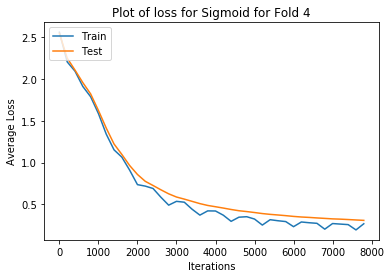

Accuracy = 0.914
Precision =  [0.93567251 0.96231884 0.9118905  0.90965732 0.91688089 0.85634847
 0.92963576 0.92270138 0.88451209 0.89487179]
Recall =  [0.96302666 0.96511628 0.87808896 0.9033256  0.92560554 0.86842105
 0.93896321 0.92722813 0.86742757 0.89030612]
F1 Score =  [0.94915254 0.96371553 0.89467058 0.9064804  0.92122256 0.86234251
 0.93427621 0.92495922 0.87588652 0.89258312]


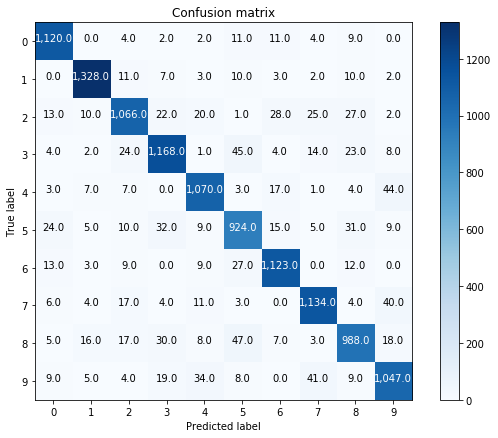

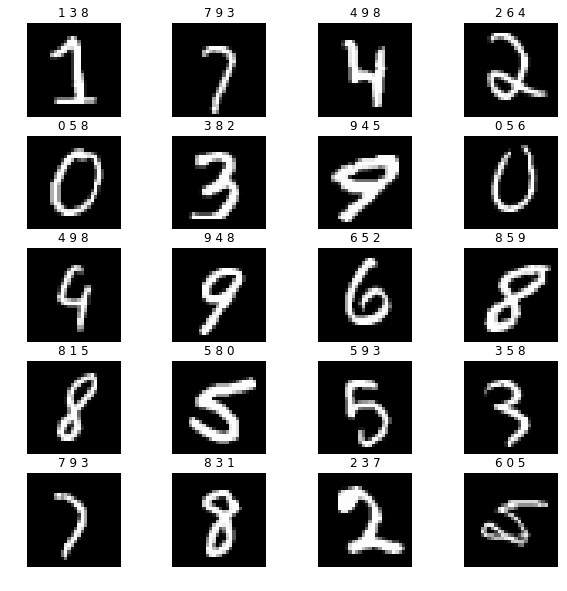

In [126]:
model3=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=3, model=model3)

### Sigmoid Activation: Fold - 5 , Learning Rate=1e-3

/home/pradeep/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 1 Iteration 1 : Avg Loss = 2.4933486187830485
Epoch 1 Iteration 201 : Avg Loss = 2.2504675255436375
Epoch 1 Iteration 401 : Avg Loss = 2.0874770044892115
Epoch 1 Iteration 601 : Avg Loss = 1.9613651308062052
Epoch 2 Iteration 1 : Avg Loss = 1.819348968824601
Epoch 2 Iteration 201 : Avg Loss = 1.5699426423902565
Epoch 2 Iteration 401 : Avg Loss = 1.331370712101686
Epoch 2 Iteration 601 : Avg Loss = 1.2693979601109229
Epoch 3 Iteration 1 : Avg Loss = 1.085148826965483
Epoch 3 Iteration 201 : Avg Loss = 0.8662746629888404
Epoch 3 Iteration 401 : Avg Loss = 0.7576723157264396
Epoch 3 Iteration 601 : Avg Loss = 0.7973557910043105
Epoch 4 Iteration 1 : Avg Loss = 0.7140385882530339
Epoch 4 Iteration 201 : Avg Loss = 0.5456361853887998
Epoch 4 Iteration 401 : Avg Loss = 0.5020232000814622
Epoch 4 Iteration 601 : Avg Loss = 0.5979665672606567
Epoch 5 Iteration 1 : Avg Loss = 0.5302615937928692
Epoch 5 Iteration 201 : Avg Loss = 0.39321665832478675
Epoch 5 Iteration 401 : Avg Loss = 0.381

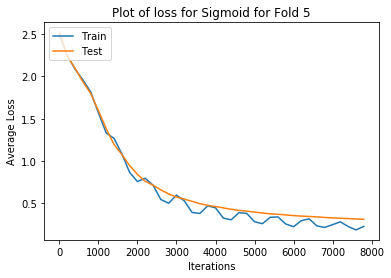

Accuracy = 0.9115833333333333
Precision =  [0.95530237 0.95803698 0.89737274 0.89264069 0.91919192 0.87619048
 0.91983806 0.90560246 0.8956373  0.88370044]
Recall =  [0.95530237 0.96906475 0.8951679  0.88270548 0.92074199 0.86223055
 0.95222129 0.93059937 0.86457473 0.86839827]
F1 Score =  [0.95530237 0.96351931 0.89626896 0.88764529 0.9199663  0.86915446
 0.93574959 0.91793077 0.87983193 0.87598253]


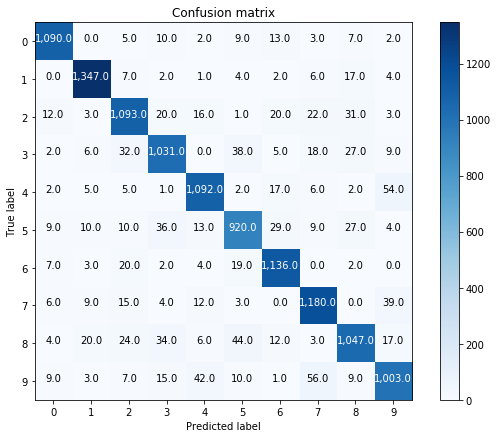

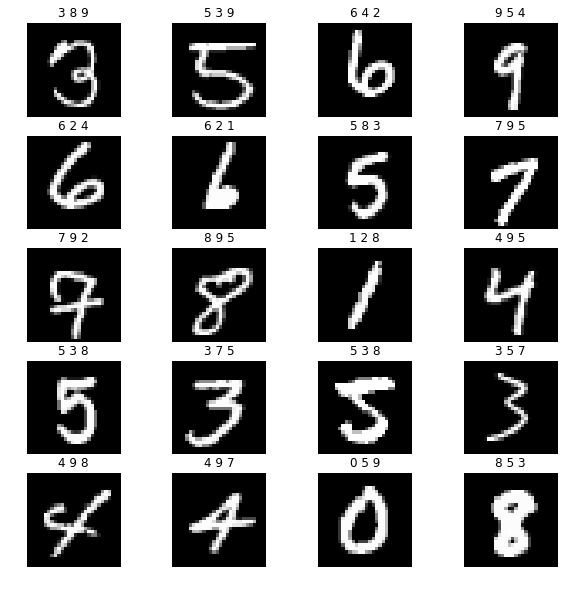

In [127]:
model4=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=4, model=model4)

### ReLU Activation: Fold - 1 , Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 2.304361100235827
Epoch 1 Iteration 201 : Avg Loss = 1.204178198370022
Epoch 1 Iteration 401 : Avg Loss = 0.3974818019518721
Epoch 1 Iteration 601 : Avg Loss = 0.36313904260308894
Epoch 2 Iteration 1 : Avg Loss = 0.3662442829822387
Epoch 2 Iteration 201 : Avg Loss = 0.11671516403836624
Epoch 2 Iteration 401 : Avg Loss = 0.21023652262570663
Epoch 2 Iteration 601 : Avg Loss = 0.17665863062170178
Epoch 3 Iteration 1 : Avg Loss = 0.15074351615516787
Epoch 3 Iteration 201 : Avg Loss = 0.0646303619408618
Epoch 3 Iteration 401 : Avg Loss = 0.16644763298063797
Epoch 3 Iteration 601 : Avg Loss = 0.12376726838051594
Epoch 4 Iteration 1 : Avg Loss = 0.1068627070188016
Epoch 4 Iteration 201 : Avg Loss = 0.03087470206139629
Epoch 4 Iteration 401 : Avg Loss = 0.10128668534212348
Epoch 4 Iteration 601 : Avg Loss = 0.12964710024929357
Epoch 5 Iteration 1 : Avg Loss = 0.08726528861334584
Epoch 5 Iteration 201 : Avg Loss = 0.025484489470511736
Epoch 5 Iteration 401 : Avg

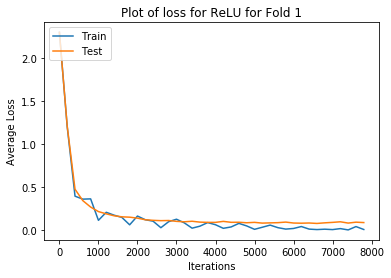

Accuracy = 0.9715833333333334
Precision =  [0.96950241 0.98934551 0.9693962  0.99042646 0.97582811 0.97098821
 0.96375618 0.97104677 0.94317218 0.9714795 ]
Recall =  [0.99342105 0.98039216 0.97261411 0.92520325 0.97495528 0.9631295
 0.99152542 0.9753915  0.9771529  0.96119929]
F1 Score =  [0.981316   0.98484848 0.97100249 0.9567045  0.9753915  0.96704289
 0.97744361 0.97321429 0.95986189 0.96631206]


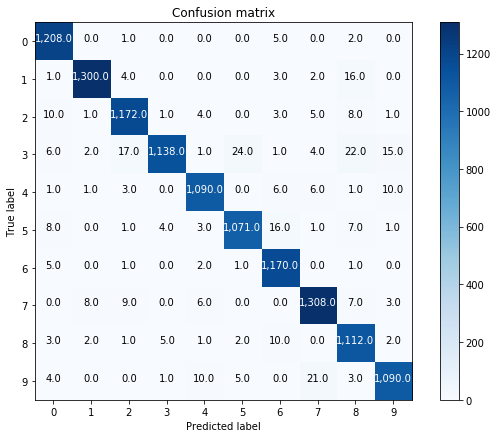

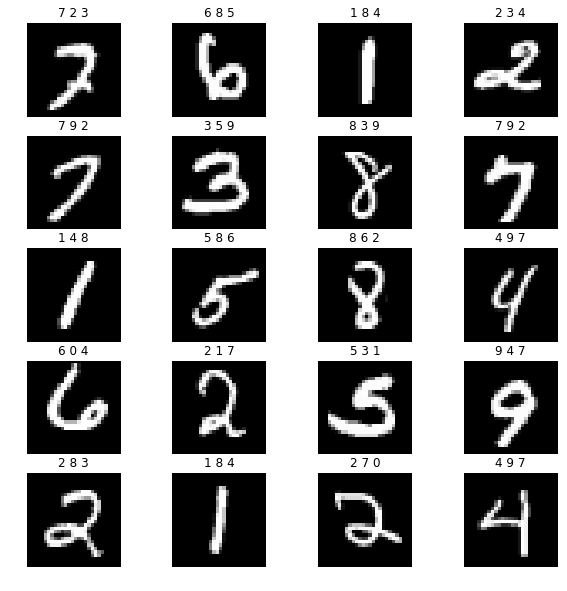

In [195]:
model0=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=0, model=model0)

### ReLU Activation: Fold - 2 , Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 2.300263084658414
Epoch 1 Iteration 201 : Avg Loss = 1.0413658602163414
Epoch 1 Iteration 401 : Avg Loss = 0.4850211932680359
Epoch 1 Iteration 601 : Avg Loss = 0.31272494746129575
Epoch 2 Iteration 1 : Avg Loss = 0.17053917853837636
Epoch 2 Iteration 201 : Avg Loss = 0.10498708487219778
Epoch 2 Iteration 401 : Avg Loss = 0.2111114296044566
Epoch 2 Iteration 601 : Avg Loss = 0.16918845868309004
Epoch 3 Iteration 1 : Avg Loss = 0.1202650022951709
Epoch 3 Iteration 201 : Avg Loss = 0.06053292407028566
Epoch 3 Iteration 401 : Avg Loss = 0.14442991392555032
Epoch 3 Iteration 601 : Avg Loss = 0.13726584290716104
Epoch 4 Iteration 1 : Avg Loss = 0.09340198265660425
Epoch 4 Iteration 201 : Avg Loss = 0.036919940419743266
Epoch 4 Iteration 401 : Avg Loss = 0.10774489903872382
Epoch 4 Iteration 601 : Avg Loss = 0.11219404330473003
Epoch 5 Iteration 1 : Avg Loss = 0.07765447388990432
Epoch 5 Iteration 201 : Avg Loss = 0.020655013125228716
Epoch 5 Iteration 401 : 

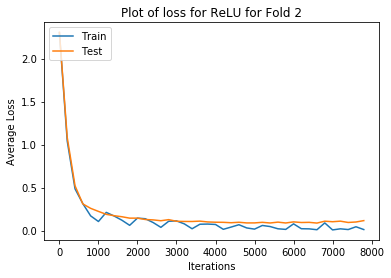

Accuracy = 0.9766666666666667
Precision =  [0.97169026 0.99242424 0.96893367 0.97350993 0.98502203 0.97034291
 0.97923588 0.97070789 0.98039216 0.97301587]
Recall =  [0.98982188 0.98570354 0.98548249 0.97350993 0.96629213 0.96944444
 0.98578595 0.98513625 0.9623431  0.96232339]
F1 Score =  [0.98067227 0.98905247 0.97713802 0.97350993 0.97556719 0.96989347
 0.9825     0.97786885 0.97128378 0.96764009]


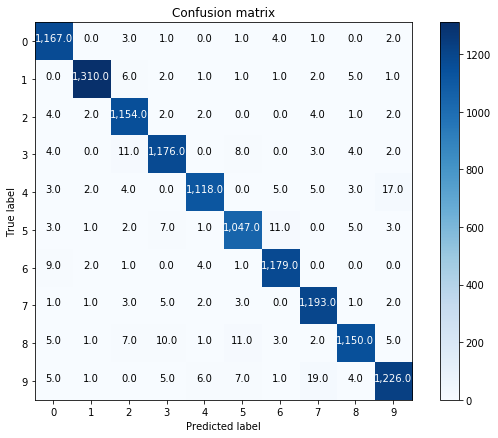

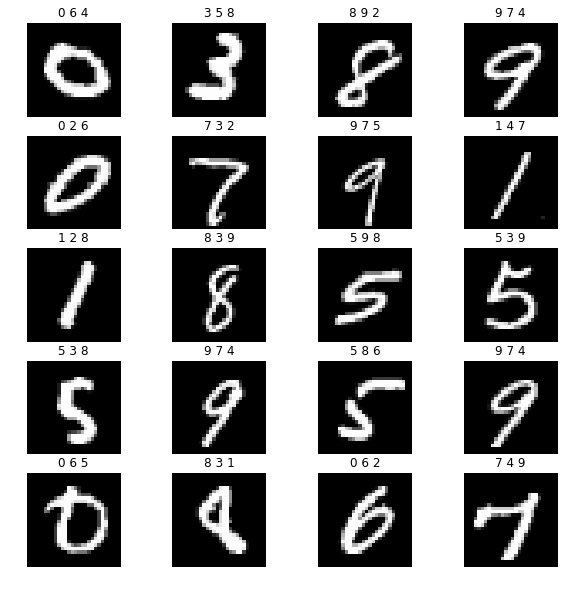

In [196]:
model1=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=1, model=model1)

### ReLU Activation: Fold - 3, Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 2.3069450430513694
Epoch 1 Iteration 201 : Avg Loss = 1.259500952414513
Epoch 1 Iteration 401 : Avg Loss = 0.4556380244813235
Epoch 1 Iteration 601 : Avg Loss = 0.34248343005659987
Epoch 2 Iteration 1 : Avg Loss = 0.18238149660132785
Epoch 2 Iteration 201 : Avg Loss = 0.2836010415440131
Epoch 2 Iteration 401 : Avg Loss = 0.21238020362395832
Epoch 2 Iteration 601 : Avg Loss = 0.20405023261993377
Epoch 3 Iteration 1 : Avg Loss = 0.11390650285045525
Epoch 3 Iteration 201 : Avg Loss = 0.20536389975661054
Epoch 3 Iteration 401 : Avg Loss = 0.08032190647381104
Epoch 3 Iteration 601 : Avg Loss = 0.13711635311855108
Epoch 4 Iteration 1 : Avg Loss = 0.10451204364699476
Epoch 4 Iteration 201 : Avg Loss = 0.14081585825116208
Epoch 4 Iteration 401 : Avg Loss = 0.04284182436299196
Epoch 4 Iteration 601 : Avg Loss = 0.10022332306779215
Epoch 5 Iteration 1 : Avg Loss = 0.09711448149468918
Epoch 5 Iteration 201 : Avg Loss = 0.10633368664543916
Epoch 5 Iteration 401 : A

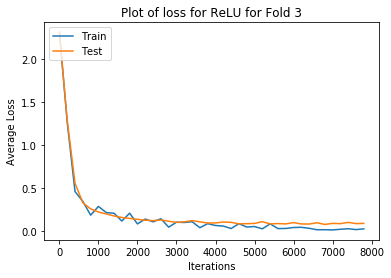

Accuracy = 0.9765833333333334
Precision =  [0.97752809 0.98429319 0.95350803 0.98897371 0.99160369 0.97272727
 0.97598628 0.96857373 0.97922078 0.97254576]
Recall =  [0.99509804 0.99621499 0.98343505 0.94642857 0.96408163 0.97449909
 0.98699046 0.98363339 0.96832192 0.9661157 ]
F1 Score =  [0.98623482 0.99021821 0.96824034 0.96723351 0.97764901 0.97361237
 0.98145752 0.97604547 0.97374085 0.96932007]


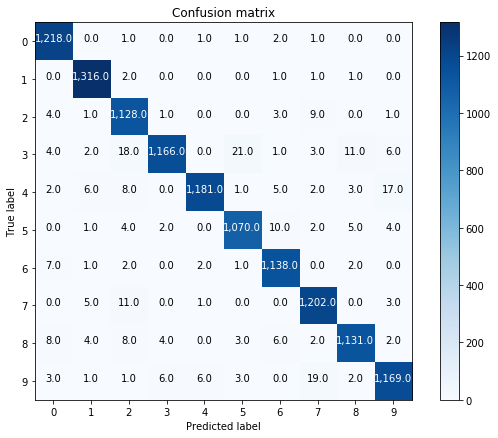

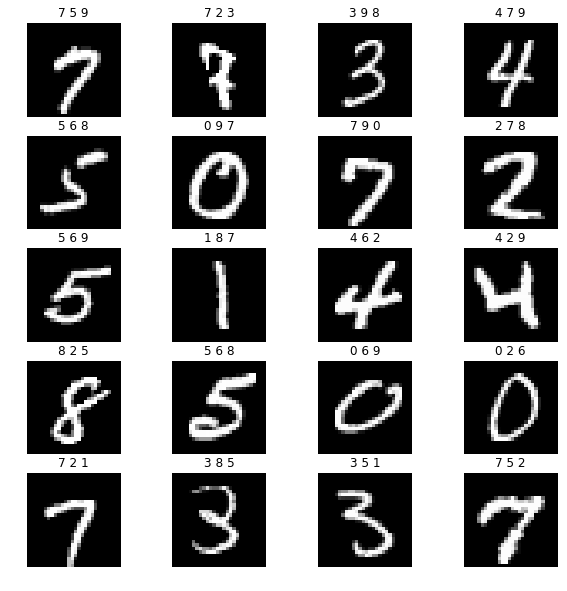

In [197]:
model2=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=2, model=model2)

### ReLU Activation: Fold - 4 , Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 2.295359359977425
Epoch 1 Iteration 201 : Avg Loss = 1.0620109707085668
Epoch 1 Iteration 401 : Avg Loss = 0.37938705465715
Epoch 1 Iteration 601 : Avg Loss = 0.3140516554938423
Epoch 2 Iteration 1 : Avg Loss = 0.17272035350795456
Epoch 2 Iteration 201 : Avg Loss = 0.30648289792988936
Epoch 2 Iteration 401 : Avg Loss = 0.09761087450220227
Epoch 2 Iteration 601 : Avg Loss = 0.17956116496377497
Epoch 3 Iteration 1 : Avg Loss = 0.1275626433964378
Epoch 3 Iteration 201 : Avg Loss = 0.24283596672752664
Epoch 3 Iteration 401 : Avg Loss = 0.05724845655421623
Epoch 3 Iteration 601 : Avg Loss = 0.1553878823425912
Epoch 4 Iteration 1 : Avg Loss = 0.0972750258851931
Epoch 4 Iteration 201 : Avg Loss = 0.19105440954656705
Epoch 4 Iteration 401 : Avg Loss = 0.07356141236650927
Epoch 4 Iteration 601 : Avg Loss = 0.1349342182882079
Epoch 5 Iteration 1 : Avg Loss = 0.06722853475814221
Epoch 5 Iteration 201 : Avg Loss = 0.14447255536904696
Epoch 5 Iteration 401 : Avg Los

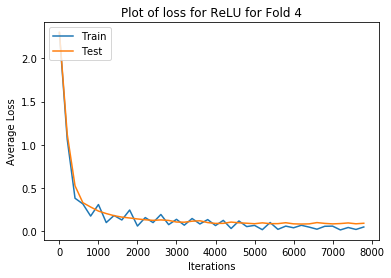

Accuracy = 0.9683333333333334
Precision =  [0.975382   0.99266324 0.95139442 0.99753492 0.96327925 0.97232824
 0.94011032 0.949327   0.95081967 0.99257196]
Recall =  [0.98796217 0.98328488 0.98352554 0.93890178 0.97577855 0.95770677
 0.99749164 0.98037612 0.96751536 0.90901361]
F1 Score =  [0.98163178 0.98795181 0.9671932  0.96733068 0.96948861 0.96496212
 0.96795132 0.96460177 0.95909487 0.94895695]


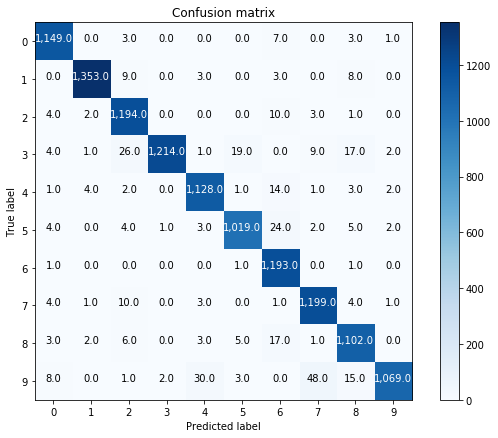

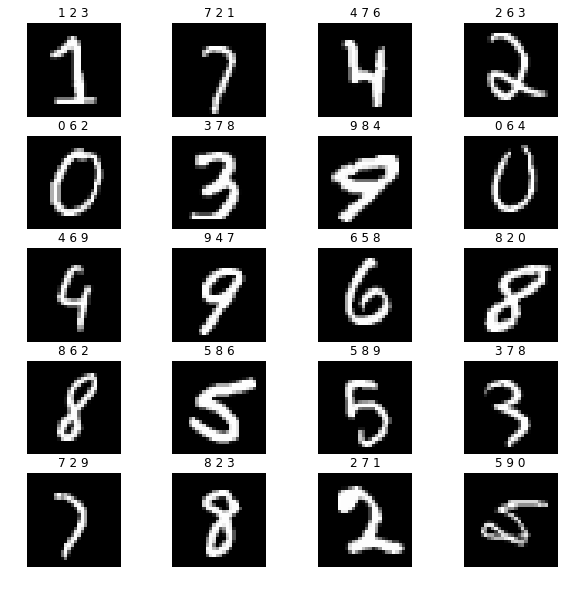

In [198]:
model3=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=3, model=model3)

### ReLU Activation: Fold-5, Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 2.3074371442176607
Epoch 1 Iteration 201 : Avg Loss = 0.47097292657759526
Epoch 1 Iteration 401 : Avg Loss = 0.1442930030421393
Epoch 1 Iteration 601 : Avg Loss = 0.1465914362445377
Epoch 2 Iteration 1 : Avg Loss = 0.2163927440538853
Epoch 2 Iteration 201 : Avg Loss = 0.22316830254666872
Epoch 2 Iteration 401 : Avg Loss = 0.10057520718428908
Epoch 2 Iteration 601 : Avg Loss = 0.13979304778444934
Epoch 3 Iteration 1 : Avg Loss = 0.21004000651702
Epoch 3 Iteration 201 : Avg Loss = 0.14059760523804285
Epoch 3 Iteration 401 : Avg Loss = 0.15029320626058745
Epoch 3 Iteration 601 : Avg Loss = 0.06803568139886099
Epoch 4 Iteration 1 : Avg Loss = 0.04395278607644029
Epoch 4 Iteration 201 : Avg Loss = 0.18914278518647173
Epoch 4 Iteration 401 : Avg Loss = 0.03432204964785391
Epoch 4 Iteration 601 : Avg Loss = 0.040420415462473346
Epoch 5 Iteration 1 : Avg Loss = 0.049507979694389
Epoch 5 Iteration 201 : Avg Loss = 0.12486389127878827
Epoch 5 Iteration 401 : Avg 

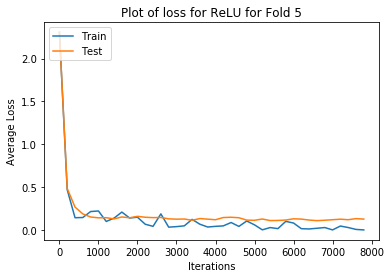

Accuracy = 0.9705
Precision =  [0.97411562 0.98566308 0.94131455 0.95699831 0.96201486 0.98252427
 0.97095436 0.97857143 0.98354978 0.970562  ]
Recall =  [0.98948291 0.98920863 0.98525799 0.97174658 0.98229342 0.94845361
 0.98072087 0.97239748 0.93806771 0.94199134]
F1 Score =  [0.98173913 0.98743268 0.96278511 0.96431606 0.97204839 0.96518836
 0.97581318 0.97547468 0.9602705  0.95606327]


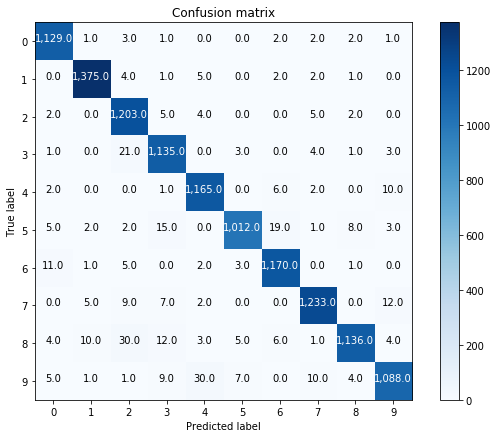

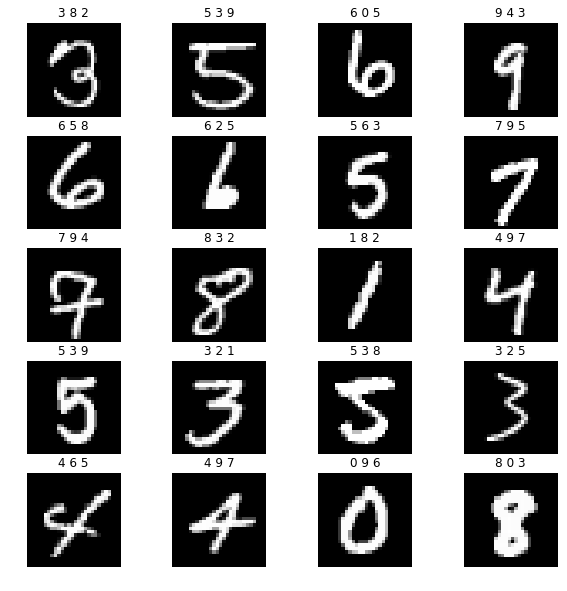

In [222]:
model4=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=4, model=model4)

### ReLU Activation + L2 - Regularization: Fold-4, Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 2.2943277370939956
Epoch 1 Iteration 201 : Avg Loss = 0.38085975487431845
Epoch 1 Iteration 401 : Avg Loss = 0.13077548830481056
Epoch 1 Iteration 601 : Avg Loss = 0.13985792396486113
Epoch 2 Iteration 1 : Avg Loss = 0.07105863638792886
Epoch 2 Iteration 201 : Avg Loss = 0.23671093735988136
Epoch 2 Iteration 401 : Avg Loss = 0.05098035838580418
Epoch 2 Iteration 601 : Avg Loss = 0.11492240587717767
Epoch 3 Iteration 1 : Avg Loss = 0.1714401131214145
Epoch 3 Iteration 201 : Avg Loss = 0.10706544796286911
Epoch 3 Iteration 401 : Avg Loss = 0.06408089360879918
Epoch 3 Iteration 601 : Avg Loss = 0.04524960586817141
Epoch 4 Iteration 1 : Avg Loss = 0.07839544620668273
Epoch 4 Iteration 201 : Avg Loss = 0.1491887025144364
Epoch 4 Iteration 401 : Avg Loss = 0.12814799104927546
Epoch 4 Iteration 601 : Avg Loss = 0.06524940083267831
Epoch 5 Iteration 1 : Avg Loss = 0.044945898432616996
Epoch 5 Iteration 201 : Avg Loss = 0.05575491736381225
Epoch 5 Iteration 401 

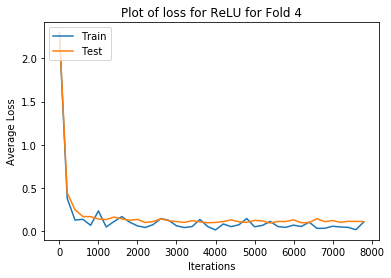

Accuracy = 0.9718333333333333
Precision =  [0.9810834  0.98750918 0.95059761 0.97280497 0.98054819 0.97607656
 0.98478445 0.96701529 0.9675723  0.9504618 ]
Recall =  [0.9810834  0.97674419 0.98270181 0.9682908  0.95934256 0.95864662
 0.97408027 0.98282911 0.96927129 0.96258503]
F1 Score =  [0.9810834  0.98209719 0.96638315 0.97054264 0.96982947 0.96728307
 0.97940311 0.97485807 0.96842105 0.956485  ]


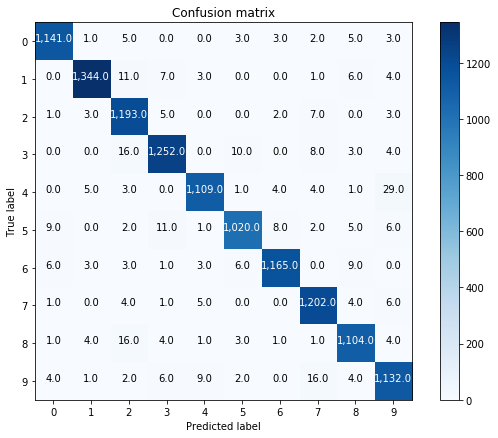

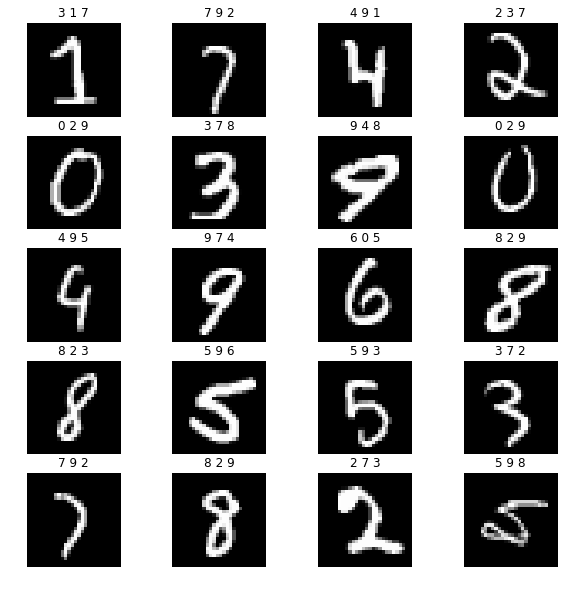

In [208]:
model3=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train(images=images, labels=labels, epochs=10, fold_index=3, model=model3)

### ReLU Activation on Noisy Data: Fold-4, Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 2.3094663643505635
Epoch 1 Iteration 201 : Avg Loss = 0.5140976510400364
Epoch 1 Iteration 401 : Avg Loss = 0.2047144462314193
Epoch 1 Iteration 601 : Avg Loss = 0.16973187596788414
Epoch 2 Iteration 1 : Avg Loss = 0.1155931323292364
Epoch 2 Iteration 201 : Avg Loss = 0.2374353000062274
Epoch 2 Iteration 401 : Avg Loss = 0.13148560932636494
Epoch 2 Iteration 601 : Avg Loss = 0.1001446076569206
Epoch 3 Iteration 1 : Avg Loss = 0.1338051046242713
Epoch 3 Iteration 201 : Avg Loss = 0.13677083928138112
Epoch 3 Iteration 401 : Avg Loss = 0.14716588540548992
Epoch 3 Iteration 601 : Avg Loss = 0.12057335206239038
Epoch 4 Iteration 1 : Avg Loss = 0.0749177964627138
Epoch 4 Iteration 201 : Avg Loss = 0.11646579722007834
Epoch 4 Iteration 401 : Avg Loss = 0.08752100378797224
Epoch 4 Iteration 601 : Avg Loss = 0.05894865343819723
Epoch 5 Iteration 1 : Avg Loss = 0.052569156532421425
Epoch 5 Iteration 201 : Avg Loss = 0.06599938821282149
Epoch 5 Iteration 401 : Avg

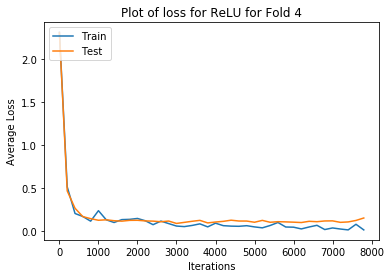

Accuracy = 0.9733333333333334
Precision =  [0.98034188 0.99048316 0.96653061 0.97352025 0.98753339 0.96786389
 0.96568627 0.98110107 0.94594595 0.9721497 ]
Recall =  [0.98624248 0.98328488 0.9752883  0.96674401 0.95934256 0.96240602
 0.98829431 0.97628782 0.9833187  0.94982993]
F1 Score =  [0.98328333 0.9868709  0.97088971 0.97012029 0.97323387 0.96512724
 0.9768595  0.97868852 0.96427034 0.96086022]


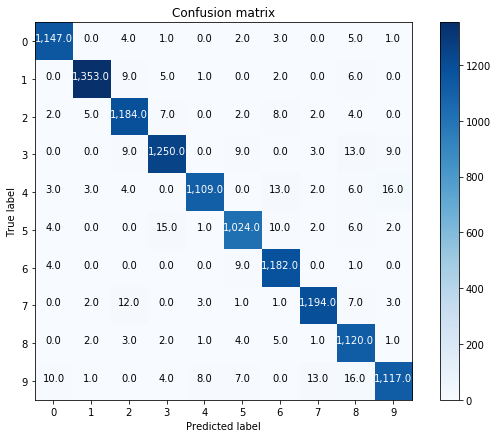

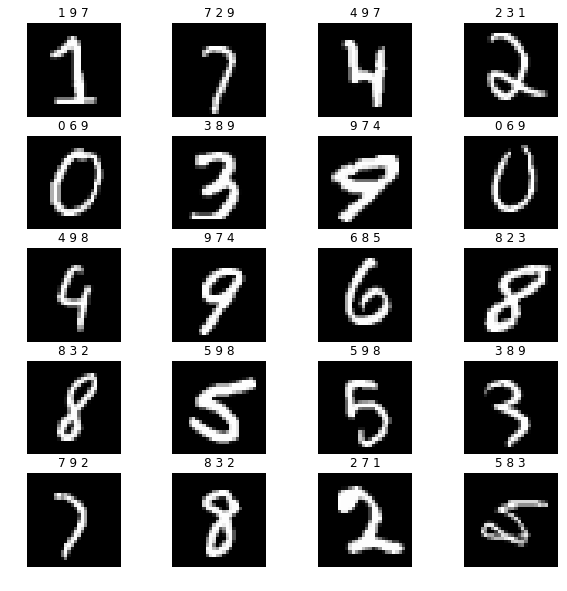

In [211]:
model3=MLP(input_size, h1_size, h2_size, h3_size, output_size)
train_noisy(images=images, labels=labels, epochs=10, fold_index=3, model=model3)